# K-means clustering of untagged intent tweets

- SpACY + POS tagging
- w2v 
- elbow method for choosing
- word cloud to visualize topics
- 

In [165]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk import word_tokenize

import matplotlib.pyplot as plt

### Load data and pre-process

In [195]:
import re
import contractions

In [415]:
# First, import/export the positive and neutral-sentiment tweets

data_path = "../data/"
raw_data = pd.read_csv(data_path + "Tweets.csv")

In [416]:
pos_tweets = raw_data[raw_data['airline_sentiment'] != 'negative']

In [417]:
intent = pos_tweets.copy()

In [418]:
import re
#import contractions

def clean_data(x):
    x = x.lower() # convert to all lower case
    x = re.sub('http\S+', '', x) # remove URLs
    x = re.sub('<.*?>', '', x) # remove HTML tags
    x = contractions.fix(x) # expand contractions
    x = re.sub('[^a-z]', ' ', x) # remove non-alphabetic characters
    x = re.sub('\s\s+', ' ', x) # remove extra whitespace
    return x

In [419]:
stopwords_eng = set(stopwords.words('english'))
intent['airline'] = intent['airline'].apply(clean_data)
airline = [word for word in intent.airline.unique()]
airline = [re.sub('\s+', '', x) for x in airline]
airline_long = [word+'air' for word in intent.airline.unique()]
airline_long = [re.sub('\s+', '', x) for x in airline_long]

intent.text = intent.text.apply(clean_data)

stopwords_eng = set(stopwords.words('english'))
stopwords_eng.update(intent.airline.unique())
stopwords_eng.update(airline)
stopwords_eng.update(['jetblue'])

stopwords_eng.update(airline_long)

In [420]:
def remove_stopwords(text):
    
    clean = ' '.join([word for word in text.split(' ') if word not in stopwords_eng])
    return clean

In [421]:
print(intent.text[0])
print(remove_stopwords((intent.text[0])))

 virginamerica what dhepburn said 
 dhepburn said 


In [422]:
intent.text = intent.text.apply(remove_stopwords)

## clustering pipeline: tf-idf + SVD + word cloud

In [423]:
#!pip install wordcloud

In [424]:
from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud

In [425]:
# To find K of K-means using elbow method.
# Plot the loss vs k graph to find the elbow point

def findK(X):
    
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}

    for k in range(2, 50):
        kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5).fit(X)
        
        distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_,
                                    'euclidean'), axis=1)) / X.shape[0])
        
        # Inertia: Sum of distances of samples to their closest cluster center
        inertias.append(kmeans.inertia_)

        mapping1[k] = sum(np.min(cdist(X, kmeans.cluster_centers_,
                                       'euclidean'), axis=1)) / X.shape[0]
        mapping2[k] = kmeans.inertia_


    fig, ax = plt.subplots(2, 1)
    ax[0].plot(list(mapping1.keys()), list(mapping1.values()))
    ax[0].set(title='Elbow method using distortions',
              xlabel="Number of clusters",
             ylabel="Loss Value")

    ax[1].plot(list(mapping2.keys()), list(mapping2.values()))
    ax[1].set(title='Elbow method using inertias',
              xlabel="Number of clusters",
             ylabel="Loss Value")
    plt.show()

In [426]:
# takes the term frequencies as a dictionary per each cluster and prints to top n terms from list
def print_top_terms(term_weights, n_terms):

    for i, counts in term_weights.items():
        print(f"Cluster {i}: ", end="")
        sorted_counts = sorted(counts.items(), key=lambda x:x[1], reverse=True)[0:n_terms]
        for term in sorted_counts:
            print(term[0], end=" ")
        print()

In [427]:
### Adopted from https://www.kaggle.com/code/albeffe/text-clustering-tfidf-pca-beginner-tutorial
# modified to: accept model parameters and return all word frequencies per cluster

def generate_frequencies(X, in_X_tfidf, k, in_word_positions, in_model):

    # Clustering
    in_y_pred = in_model.fit_predict(X)
    in_cluster_ids = set(in_y_pred)
    silhouette_avg = silhouette_score(X, in_y_pred)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)

    # Number of words with highest tfidf score to display
    top_count = 100
    
    cluster_frequencies = {}

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        cluster_frequencies[in_cluster_id] = term_weights
        
    return cluster_frequencies

In [428]:
def generate_wordclouds(frequencies, filename):
    
    for in_cluster_id, term_weights in frequencies.items():
        
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {in_cluster_id}")
        
        fig.savefig(filename.split('.png')[0]+'_cluster={}.png'.format(in_cluster_id))
        plt.show()

### Finding best model based on: sensibility of word cloud groups, cluster silhouette values

Possible parameters to explore:
- pre-processing options
- optimal K
- word embedding
- dimensionality reduction choice (n_components, SVD/UMAP/etc)

In [429]:
# Using tf-idf to vectorize documents by BoW
vectorizer = TfidfVectorizer(min_df=5, max_df=.5)
X_tfidf = vectorizer.fit_transform(intent.text)

word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}

In [430]:
X_tfidf.shape

(5462, 1311)

In [431]:
# use svd to reduce dimensionality
svd = TruncatedSVD(n_components=30, random_state=42)
X_svd = svd.fit_transform(X_tfidf)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.20


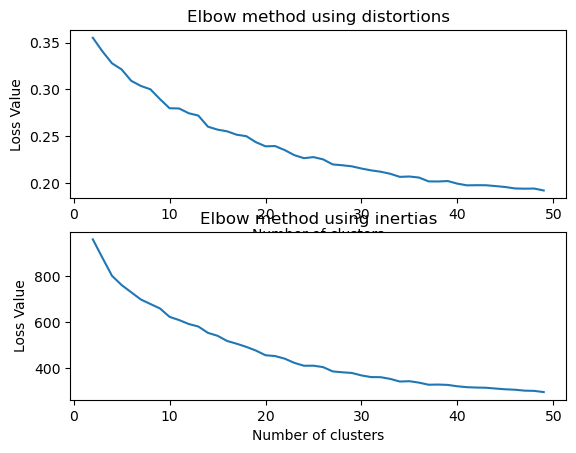

In [432]:
findK(X_svd)

Choosing cluster = 4 for n_components = 30 -- seems to be a dip/inflection point right after k=5 in distortions, and between 4-6 for inertias

In [433]:
# todo: put all into a scoring/testing function -- takes in different models, X_values
k = 4
modelname = 'kmeans_no_airlines'

kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5)
freqs = generate_frequencies(X_svd, X_tfidf, k, word_positions, kmeans)
print_top_terms(freqs, 10)
out_filename = '../figures/wordcloud_model={}_k={}_n_components={}.png'.format(
                                                                        modelname,
                                                                        kmeans.n_clusters,
                                                                        X_svd.shape[1]
                                                                        )

For n_clusters = 4 The average silhouette_score is : 0.41418509694711503
Cluster 0: flight thanks get please great dm love would help flights 
Cluster 1: thank much great response ok okay help sent awesome appreciate 
Cluster 2: thanks much awesome sent ok made got update flight help 
Cluster 3: fleek fleet rt lol lmao wow stop oh happened real 


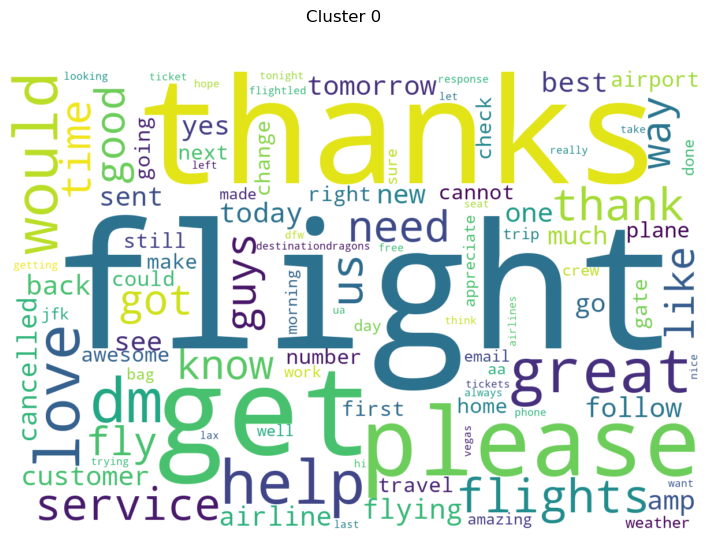

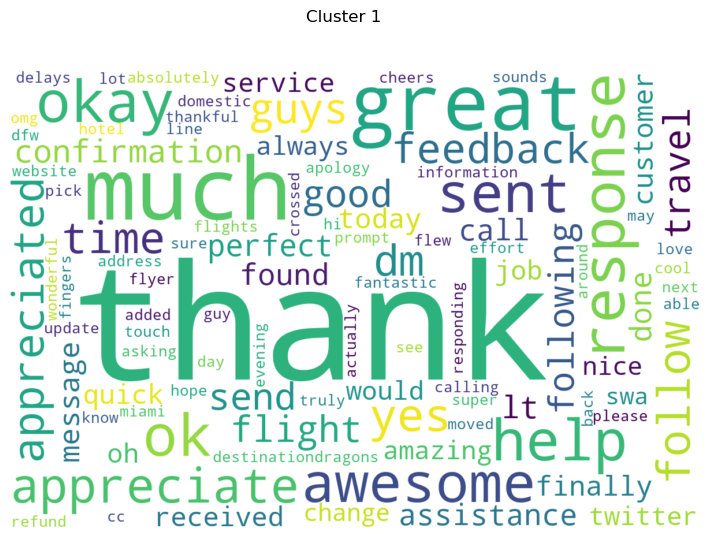

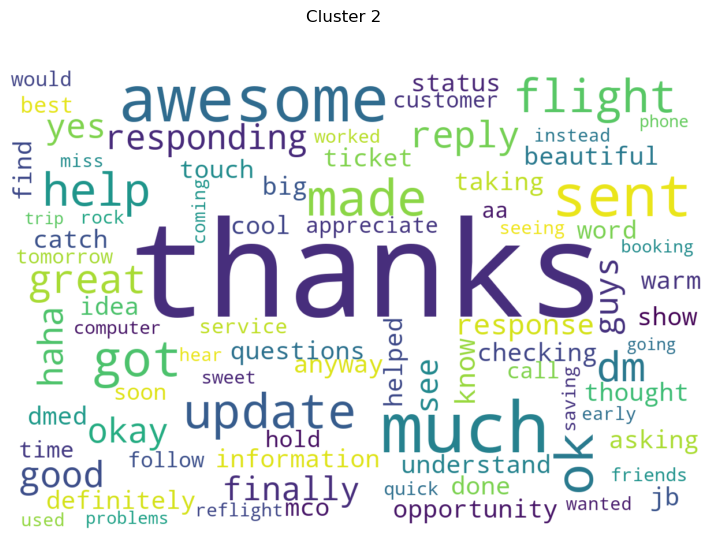

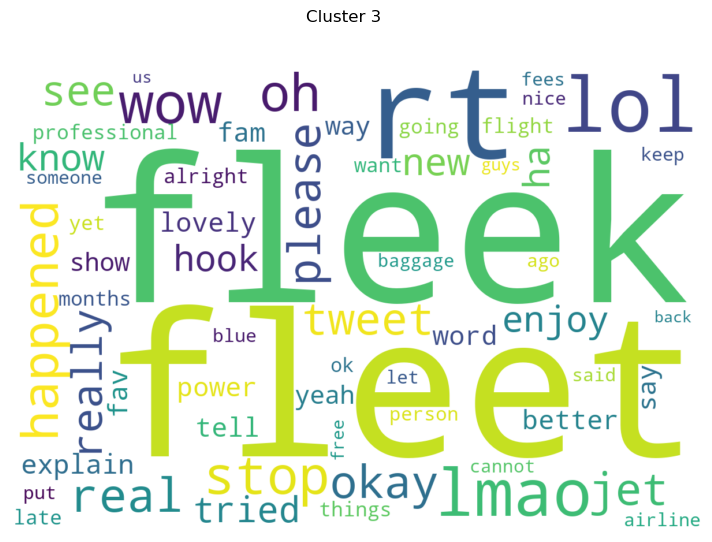

In [434]:
# I like that cluster 3 is a good example of funny tweets
out_filename = '../figures/wordcloud_model={}_k={}_n_components={}.png'.format(
                                                                        "small_kmeans_noairlines",
                                                                        kmeans.n_clusters,
                                                                        X_svd.shape[1]
                                                                        )
generate_wordclouds(freqs, out_filename)

In [435]:
# Using higher value for truncated SVD == keeping more of the words and increasing the explained variance

# use svd to reduce dimensionality
svd = TruncatedSVD(n_components=200, random_state=42)
X_svd = svd.fit_transform(X_tfidf)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.52


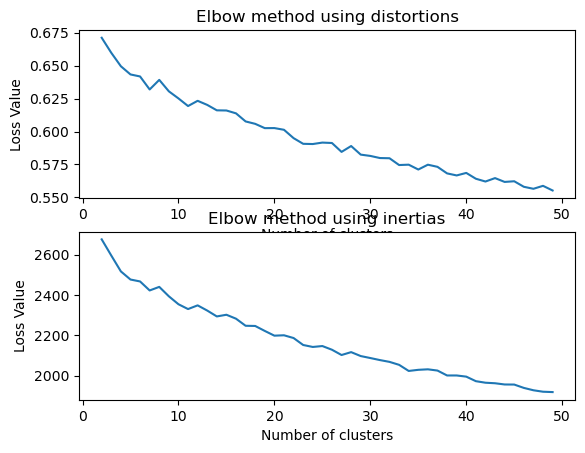

In [436]:
findK(X_svd)

Choosing cluster = 8 for n_components = 200 -- seems to be a dip/inflection point right after k=11

In [439]:
k = 4
modelname = 'kmeans_no_airlines'

kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5)
freqs = generate_frequencies(X_svd, X_tfidf, k, word_positions, kmeans)
print_top_terms(freqs, 10)

For n_clusters = 4 The average silhouette_score is : 0.14567489948694892
Cluster 0: fleek fleet rt lol lmao wow stop oh happened real 
Cluster 1: flight thanks get please love would help dm flights great 
Cluster 2: thank much great response ok okay help sent awesome follow 
Cluster 3: thanks much got sent great awesome flight dm ok good 


In [440]:
# todo: put all into a scoring/testing function -- takes in different models, X_values
k = 8
modelname = 'kmeans_no_airlines'

kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5)
freqs = generate_frequencies(X_svd, X_tfidf, k, word_positions, kmeans)
print_top_terms(freqs, 10)

For n_clusters = 8 The average silhouette_score is : 0.08257282391591787
Cluster 0: fleek fleet rt lol lmao wow stop oh happened real 
Cluster 1: already thanks made flight get rr thank still trip like 
Cluster 2: thanks much awesome got ok great flight made update sent 
Cluster 3: thank much great response ok okay help awesome follow time 
Cluster 4: need help flight please get change cancelled reservation work possible 
Cluster 5: pass boarding companion tsa get pre please passbook thanks passes 
Cluster 6: dm sent follow please thanks info confirmation thank back help 
Cluster 7: flight thanks get love great would flights thank please service 


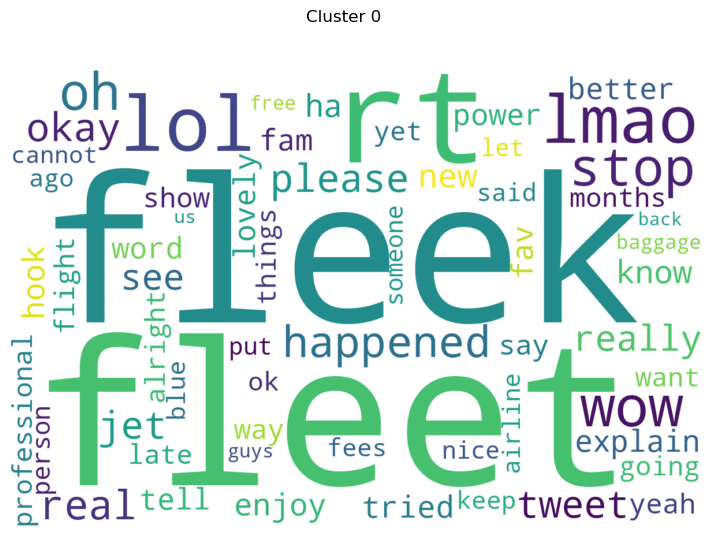

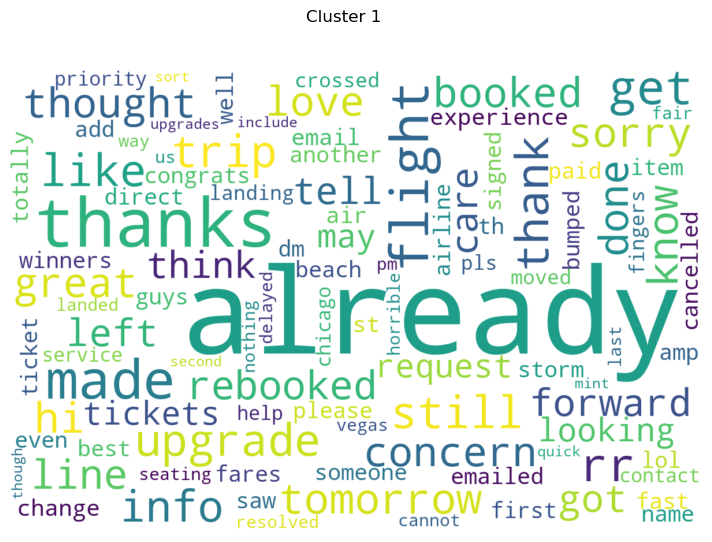

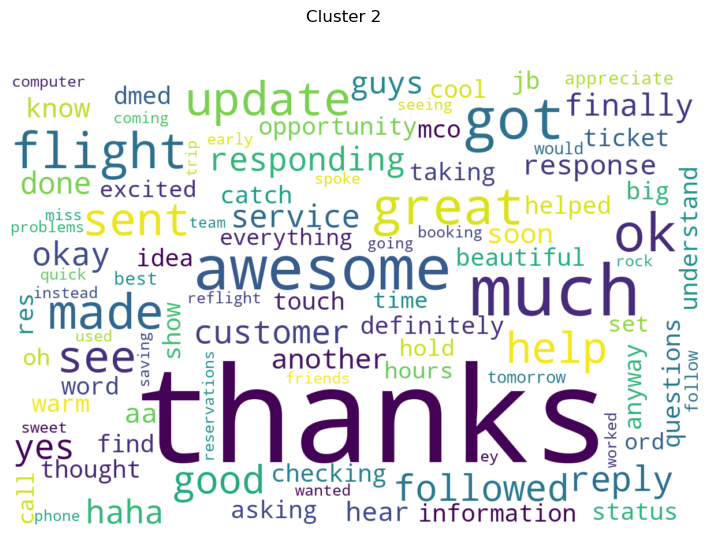

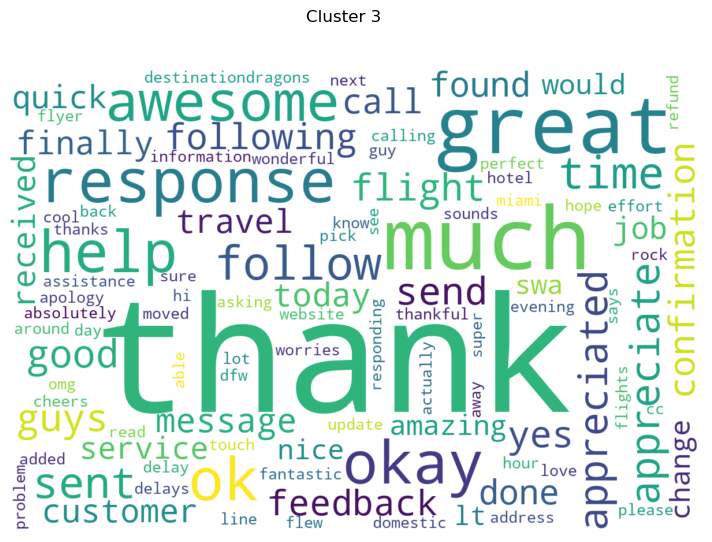

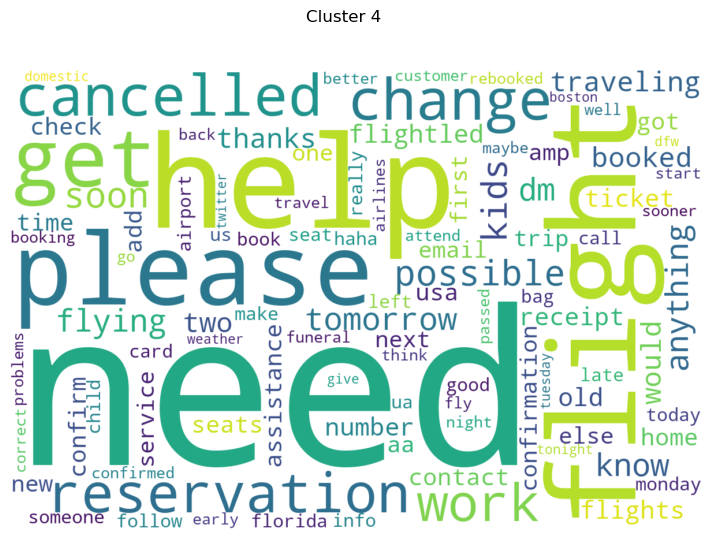

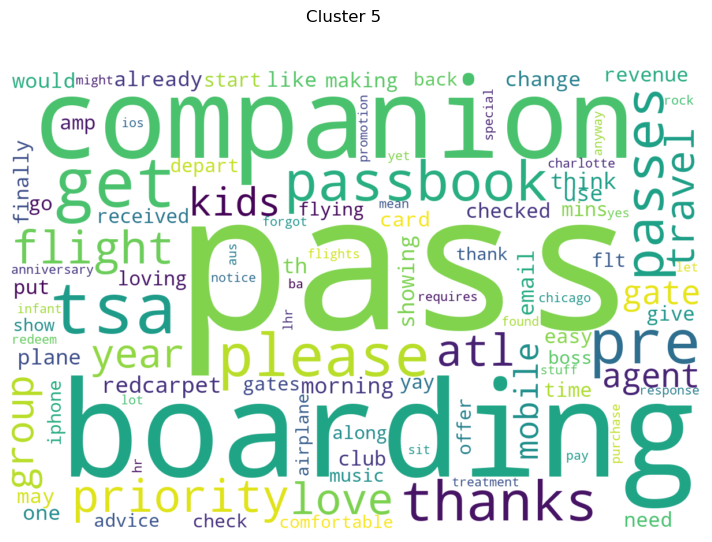

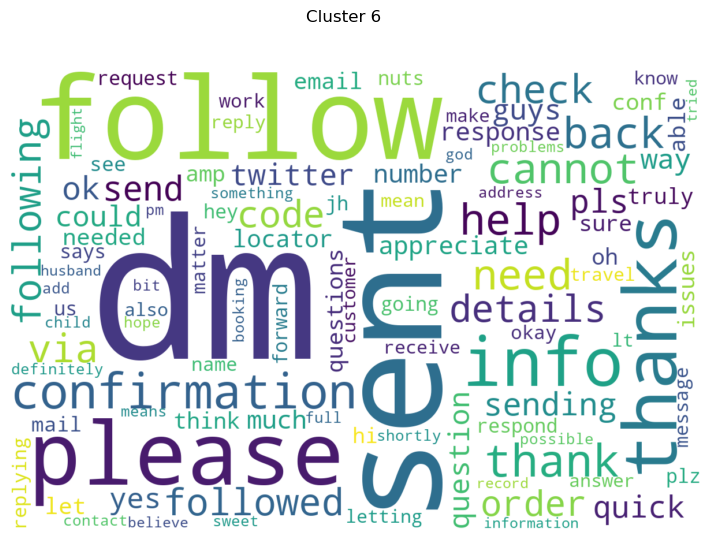

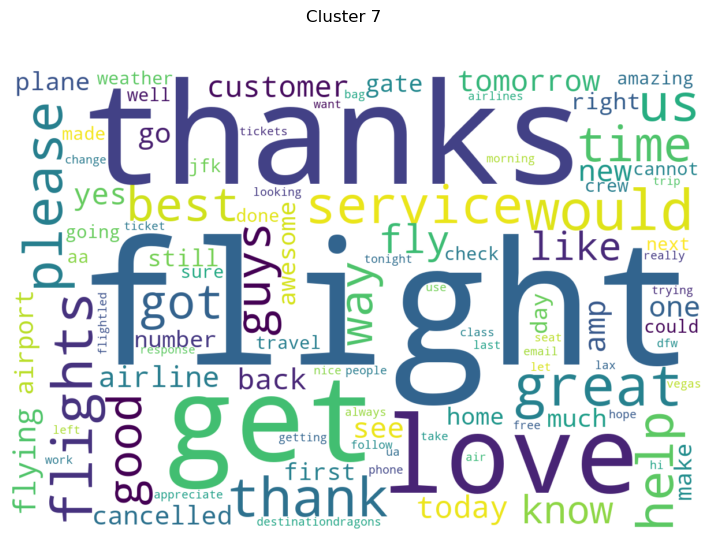

In [441]:
# these ones somewhate make sense == generating wordclouds
out_filename = '../figures/wordcloud_model={}_k={}_n_components={}.png'.format(
                                                                        'kmeans_no_airlines_thanks_categorized',
                                                                        kmeans.n_clusters,
                                                                        X_svd.shape[1]
                                                                        )
generate_wordclouds(freqs, out_filename)

### Description of 8 categories above:

- Cluster 0: Slang and fun twitter comments
- Cluster 1: Has to do with timing, booking, most people seem to be requesting help 
- Cluster 2: Thanking: mostly seems to be positive reviews of customer service
- Cluster 3: Thanking: mostly seems to be positive reviews of customer service, more associated with feedback of some kind
- Cluster 4: Requests: people with questions looking for help with booking, flight or reservation changes, wanting timely attention 
- Cluster 5: Passes, boarding, seems to be a combination of praise and requests 
- Cluster 6: People referencing or requesting correspondence, specifically electronically or through twitter
- Cluster 7: People generally talking about flights, mostly positively 

### Dev Zone: Generating wordclouds and top features

Using our best number of components for dimensionality reduction and k-value for clustering, let's look at the most representative words for describing each cluster

- [x] word cloud visualizations
- [x] most frequent set of words in each cluster
- [ ] (optional?) Clustering on cosine word similarity // maybe distance to centroid 

In [ ]:
# todo: write function for all_cluster_silhouettes + print

For n_clusters = 10 The average silhouette_score is : 0.04746355893688167
Cluster 0: virginamerica co http to you the on for in is 
Cluster 1: usairways to the thanks is flight for on you and 
Cluster 2: do you to not have will my southwestair the jetblue 
Cluster 3: fleek fleet our http co on jetblue rt this lol 
Cluster 4: dm follow you sent me please can united southwestair americanair 
Cluster 5: southwestair to the for you thanks is co my flight 
Cluster 6: americanair thanks the to is for flight you on it 
Cluster 7: thank you united southwestair jetblue americanair usairways for much will 
Cluster 8: jetblue to the thanks co http you for is flight 
Cluster 9: united to the thanks for is flight on it you 


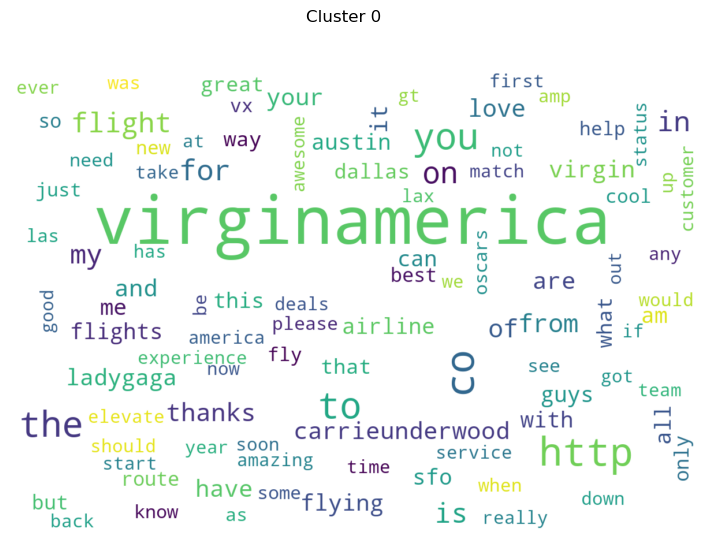

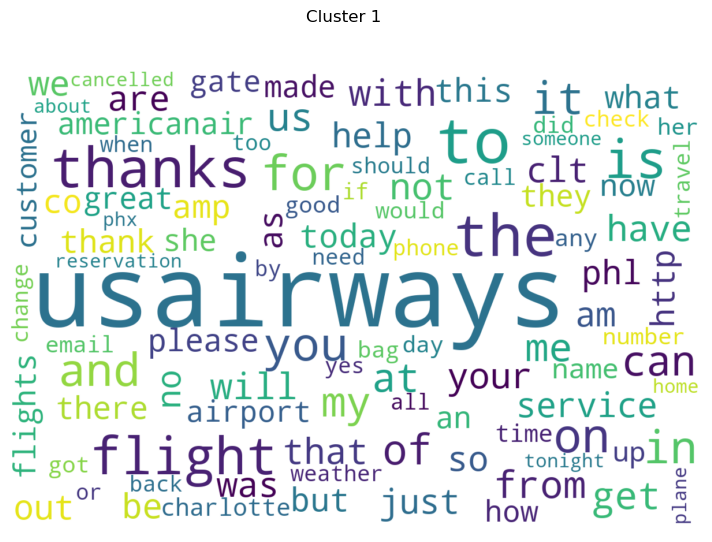

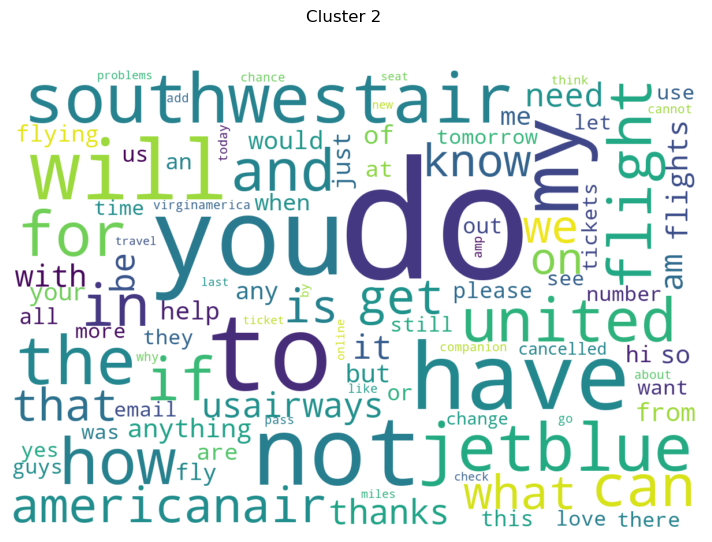

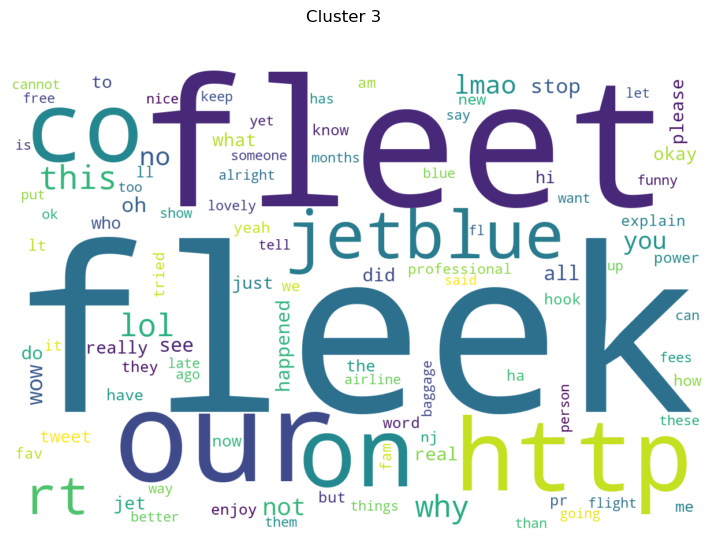

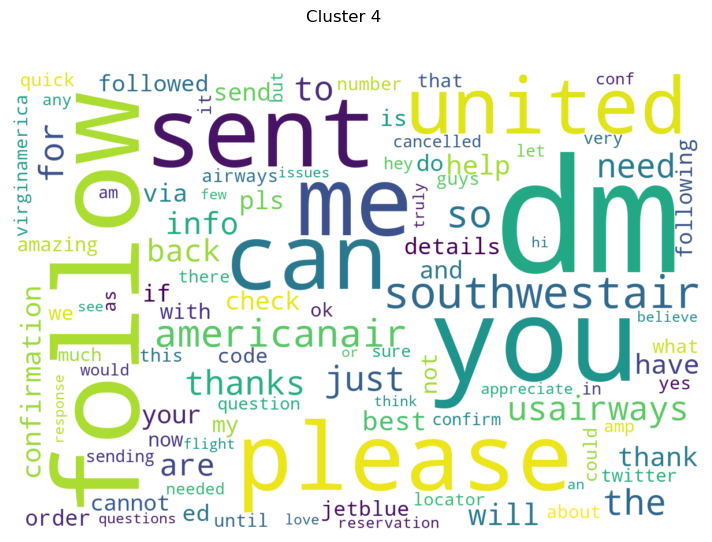

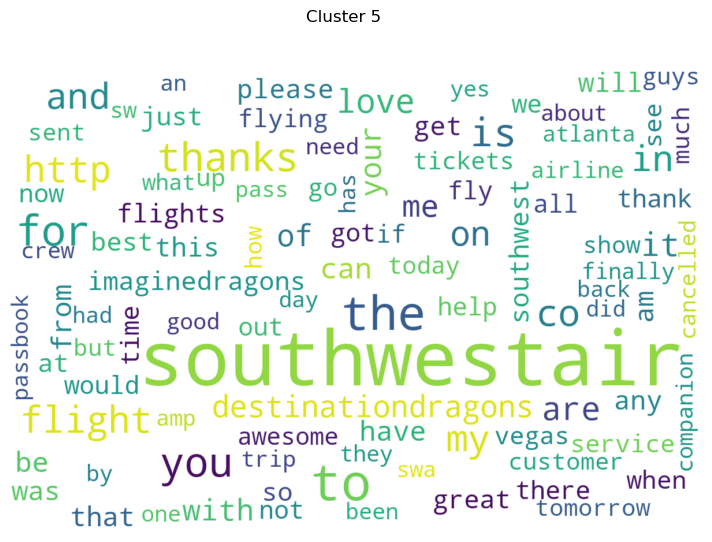

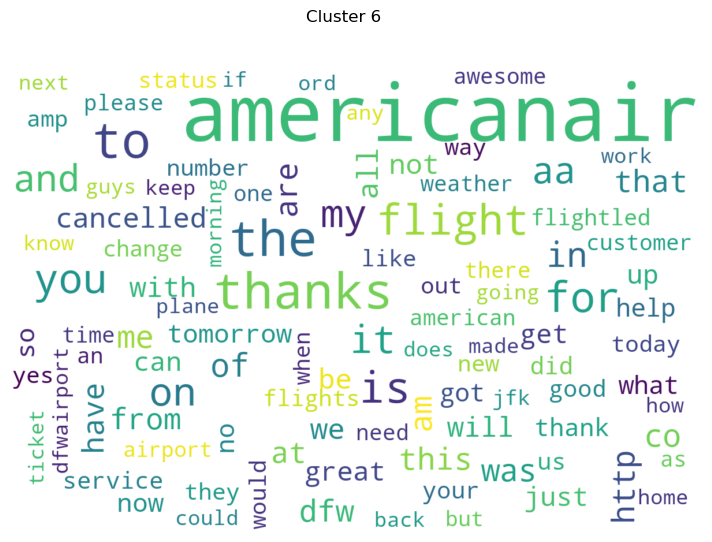

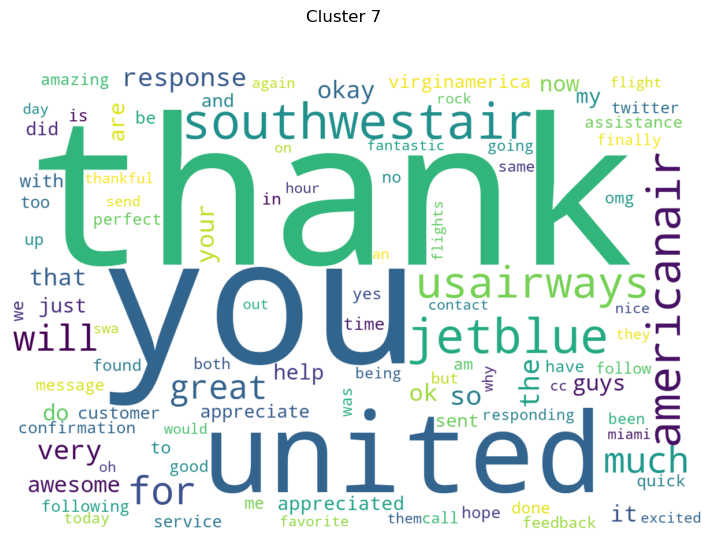

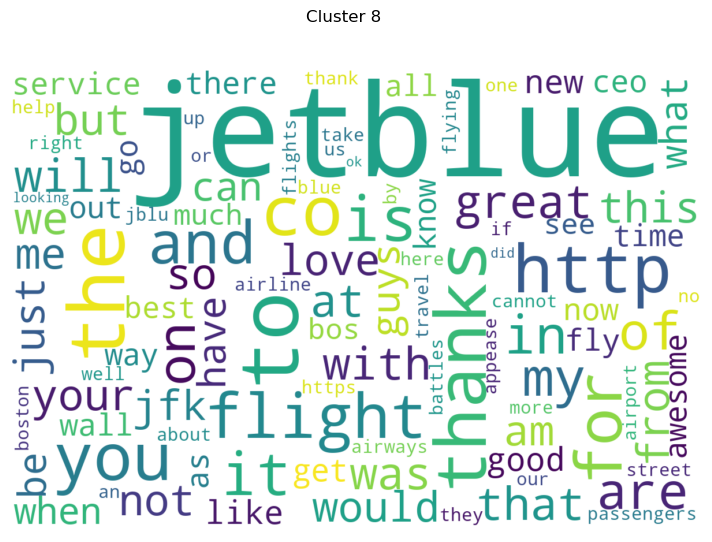

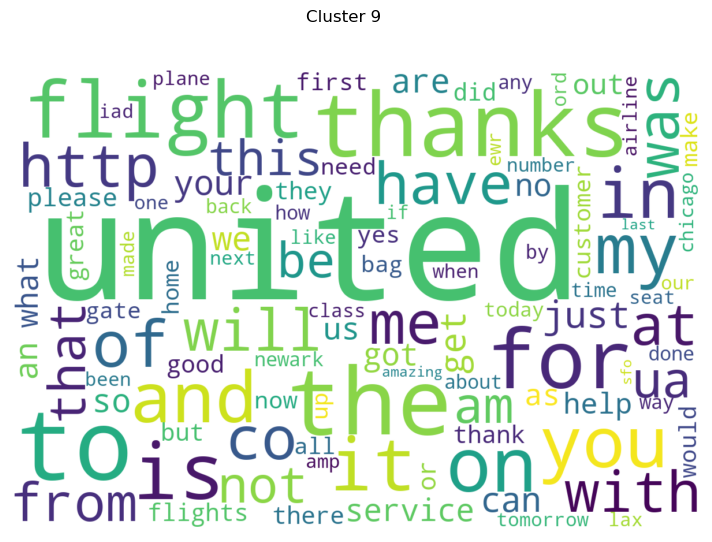

In [346]:
# todo: put all into a scoring/testing function -- takes in different models, X_values
k = 6
modelname = 'kmeans_no_airlines'

kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5)
freqs = generate_frequencies(X_svd, X_tfidf, k, word_positions, kmeans)
print_top_terms(freqs, 10)
out_filename = '../figures/wordcloud_model={}_k={}_n_components={}.png'.format(
                                                                        modelname,
                                                                        kmeans.n_clusters,
                                                                        X_svd.shape[1]
                                                                        )

In [ ]:
generate_wordclouds(freqs, out_filename)

## Alternative dimensionality reduction: UMAP (for tf-idf still)

In [ ]:
X_umap = umap.UMAP(random_state=1, n_components=30).fit_transform(X_tfidf)

## Trying: alternative word embeddings

- [ ] w2v, repeat above 
       - can I use same functions?
- [ ] including POS tagging for documents
- [ ] repeat clustering with this vectorization

In [ ]:
!pip install sense2vec

In [167]:
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

import sense2vec
from sense2vec import Sense2VecComponent

In [442]:
data_path = "../data/"

intent = pd.read_csv(data_path + "intent_Tweets.csv", index_col=0)

In [443]:
nlp = spacy.load("en_core_web_sm")
s2v = nlp.add_pipe("sense2vec")
s2v.from_disk(data_path + "s2v_reddit_2015_md")

In [170]:
small_intent = intent.text[0:10]

In [444]:
nlp(intent.text[0])

ValueError: [E090] Extension '_s2v' already exists on Doc. To overwrite the existing extension, set `force=True` on `Doc.set_extension`.

In [172]:
most_similar,freq

([(('agressive', 'ADJ'), 0.9016),
  (('aggresive', 'ADJ'), 0.8805),
  (('aggressively', 'ADV'), 0.8017)],
 114729)

In [173]:
X.type()

AttributeError: 'spacy.tokens.doc.Doc' object has no attribute 'type'

### Using max halford's centroid embedding

generating some centroid

--> maybe could weight the centroid based on words we know correspond with intent ("wanted", "cool", "thanks")...

In [95]:
import numpy as np

def embed(tokens, nlp):
    """Return the centroid of the embeddings for the given tokens.

    Out-of-vocabulary tokens are cast aside. Stop words are also
    discarded. An array of 0s is returned if none of the tokens
    are valid.

    """

    #lexemes = (nlp.vocab[token] for token in tokens)
    doc = nlp(tokens)
    
    vectors = [word._.s2v_vec for word in doc if not word._.s2v_vec is None]
    
    vectors = np.asarray(vectors)
    
#     vectors = np.asarray([
#         lexeme.vector
#         for lexeme in lexemes
#         if lexeme.has_vector
#         and not lexeme.is_stop
#         and len(lexeme.text) > 1
#     ])

    if len(vectors) > 0:
        centroid = vectors.mean(axis=0)
    else:
        width = nlp.meta['vectors']['width']  # typically 300
        centroid = np.zeros(width)

    return centroid

In [174]:
tokens = intent.text[0]

In [175]:
nlp(intent.text[0])

ValueError: [E090] Extension '_s2v' already exists on Doc. To overwrite the existing extension, set `force=True` on `Doc.set_extension`.

In [124]:
centroid = embed(tokens, nlp)

ValueError: [E090] Extension '_s2v' already exists on Doc. To overwrite the existing extension, set `force=True` on `Doc.set_extension`.

In [107]:
def embed_loader(text):
    return (embed(text, nlp))

In [120]:
small_intent.apply(lambda x: embed_loader(x))

ValueError: [E090] Extension '_s2v' already exists on Doc. To overwrite the existing extension, set `force=True` on `Doc.set_extension`.

In [101]:
nlp.meta

{'lang': 'en',
 'name': 'core_web_sm',
 'version': '3.4.1',
 'description': 'English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.',
 'author': 'Explosion',
 'email': 'contact@explosion.ai',
 'url': 'https://explosion.ai',
 'license': 'MIT',
 'spacy_version': '>=3.4.0,<3.5.0',
 'spacy_git_version': '2b5f955c2',
 'vectors': {'width': 0,
  'vectors': 0,
  'keys': 0,
  'name': None,
  'mode': 'default'},
 'labels': {'tok2vec': [],
  'tagger': ['$',
   "''",
   ',',
   '-LRB-',
   '-RRB-',
   '.',
   ':',
   'ADD',
   'AFX',
   'CC',
   'CD',
   'DT',
   'EX',
   'FW',
   'HYPH',
   'IN',
   'JJ',
   'JJR',
   'JJS',
   'LS',
   'MD',
   'NFP',
   'NN',
   'NNP',
   'NNPS',
   'NNS',
   'PDT',
   'POS',
   'PRP',
   'PRP$',
   'RB',
   'RBR',
   'RBS',
   'RP',
   'SYM',
   'TO',
   'UH',
   'VB',
   'VBD',
   'VBG',
   'VBN',
   'VBP',
   'VBZ',
   'WDT',
   'WP',
   'WP$',
   'WRB',
   'XX',
   '_SP',
   '``'],
  'parser': ['RO

In [69]:
word = nlp.vocab['aggressive']

In [88]:
vectors = [word._.s2v_vec for word in doc if not word._.s2v_vec is None]

In [94]:
np.asarray(vectors).mean(axis=0)

array([ 0.11348016,  0.1511113 , -0.11458497, -0.00719444, -0.12384169,
       -0.14170755,  0.11654484,  0.12051272, -0.2831627 , -0.20125876,
        0.06453156, -0.09362862, -0.00741946,  0.10232781,  0.0204888 ,
       -0.23061994, -0.02579482,  0.1078625 ,  0.20312749, -0.03996178,
       -0.03794886,  0.0091996 ,  0.14502046, -0.05797819,  0.03089156,
       -0.18553092,  0.05945851,  0.22633702, -0.06000602, -0.09302802,
        0.06192324, -0.1988912 ,  0.06464406,  0.09407662, -0.08722547,
       -0.04159675,  0.05727575, -0.06218077,  0.09627423, -0.17503738,
        0.01237134,  0.08094307, -0.05190232, -0.10072535,  0.13649186,
        0.00289481,  0.07678462, -0.01057643, -0.12381575, -0.04805648,
        0.0438864 , -0.13981251,  0.03346838,  0.11389402, -0.13906963,
       -0.04729424,  0.19798037, -0.01312162, -0.00062124,  0.10652015,
       -0.09496076,  0.08839503,  0.01742469, -0.00991225, -0.16113997,
       -0.08514154,  0.11798079, -0.12597549, -0.02118784, -0.04

In [62]:
lexeme = nlp.vocab['aggressive']

In [63]:
lexeme.has_vector

False